In [16]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import config
from datetime import datetime
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [ ]:
train_features.index

In [ ]:
sfk = StratifiedKFold()

In [27]:
t = []
for m, n in kf:
    t.append(n)
t = np.concatenate(t)

In [31]:
 set(range(len(train_features))) -set(t)

    

set()

In [4]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import config
features_importance = pd.read_csv(config.IN_FEAT_IMPORTANCE, index_col=0)
def select_features(i):
    return features_importance[:i].index.tolist()

# Load data

In [5]:
test_features_hand = pd.read_csv(config.IN_TEST_FEAT_HAND, index_col=0, usecols=['test_id'] + select_features(160))
test_features_dl = pd.read_csv(config.IN_TEST_FEAT_DL, index_col=0)

test_features_hand['magic_intersect_0'] = test_features_hand['magic_intersect'] == 0
test_features_hand['magic_intersect_1'] = test_features_hand['magic_intersect'] == 1
test_features_hand['magic_intersect_2'] = test_features_hand['magic_intersect'] == 2
test_features_hand['magic_intersect_3'] = test_features_hand['magic_intersect'] >=3

In [6]:
test_features_leak = test_features_hand['magic_intersect']
test_features_hand = test_features_hand.drop(['magic_intersect'], axis=1)
test_features = pd.concat([test_features_dl, test_features_hand], axis=1)

In [35]:
pd.concat([train_features[['magic_max-freq','magic_min-freq']], train_features_leak], axis=1).to_csv('train_features_leak.csv')

In [40]:
name = '/Users/shawn/Git/Kaggle_Quora/Tmp/Train/lower_rmpunctuation_tokenize_glove.6B.300d_feature_dl_0.244928_0.003516.csv'
train_dl = pd.read_csv(name, index_col=0)
test_dl = pd.read_csv('/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_glove.6B.300d_feature_dl_0.244928_0.003516.csv', index_col=0)

In [8]:
train_features_hand = pd.read_csv(config.IN_TRAIN_FEAT_HAND, index_col=0, usecols=['id']+select_features(160))
train_features_dl = pd.read_csv(config.IN_TRAIN_FEAT_DL, index_col=0)

train_features_hand['magic_intersect_0'] = train_features_hand['magic_intersect'] == 0
train_features_hand['magic_intersect_1'] = train_features_hand['magic_intersect'] == 1
train_features_hand['magic_intersect_2'] = train_features_hand['magic_intersect'] == 2
train_features_hand['magic_intersect_3'] = train_features_hand['magic_intersect'] >=3

train_label = np.load(config.IN_TRAIN_LABEL)

In [9]:
train_features_leak = train_features_hand['magic_intersect']
train_features_hand = train_features_hand.drop(['magic_intersect'], axis=1)
train_features = pd.concat([train_features_dl, train_features_hand], axis=1)

In [11]:
import pickle
kf = pickle.load(open(config.KFOLD_FILE, 'rb'), encoding='bytes')

In [ ]:
def get_train_test_features(kf, train_features, train_label, test_features):
    ## hyper parameter
    HYPER_PARAM = {
        'num_leaves': 50,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'feature_fraction' : 0.8,
        'bagging_fraction' : 0.8
    }
    NUM_ROUND = 200000
    EARLY_STOP = 50
    K_FOLD = 10

    ## cross validation
    test_feature = []
    train_feature = []
    eval_loss = []
    best_iter = []
    for i, (train_index, dev_index) in enumerate(kf):
        train_data = lgb.Dataset(train_features.iloc[train_index], label=train_label[train_index])
        dev_data = lgb.Dataset(train_features.iloc[dev_index], label=train_label[dev_index])
        
        print('Training the %dth model...' % i)
        start_time = datetime.now()
        bst = lgb.train(HYPER_PARAM,
                        train_data,
                        verbose_eval=10,
                        valid_sets=[train_data, dev_data],
                        valid_names=['Train', 'Dev'],
                        num_boost_round=NUM_ROUND,
                        early_stopping_rounds=EARLY_STOP)
        print('Use time: {}'.format(datetime.now()-start_time))
        best_iter.append(bst.best_iteration)
        eval_loss.append(bst.best_score['Dev']['binary_logloss'])
        test_feature.append(bst.predict(test_features))
        train_feature.append(pd.DataFrame(index=dev_index, data={'is_duplicate': bst.predict(train_features.iloc[dev_index])}))
    train_feature = pd.concat(train_feature).sort_index()
    test_feature = np.stack(test_feature).mean(0)
    test_feature = pd.DataFrame(index=test_features.index, data={'is_duplicate':test_feature})

    mean = np.mean(eval_loss)
    std = np.std(eval_loss)
    best_iter = int(np.mean(best_iter))
    return train_feature,test_feature, mean, std, best_iter

In [13]:
def get_train_features(kf, train_features, train_label):
    ## hyper parameter
    HYPER_PARAM = {
        'num_leaves': 50,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'feature_fraction' : 0.8,
        'bagging_fraction' : 0.8
    }
    
    NUM_ROUND = 200000
    EARLY_STOP = 50
    K_FOLD = 10

    ## cross validation
    train_feature = []
    eval_loss = []
    best_iter = []
    for i, (train_index, dev_index) in enumerate(kf):
        train_data = lgb.Dataset(train_features.iloc[train_index], label=train_label[train_index])
        dev_data = lgb.Dataset(train_features.iloc[dev_index], label=train_label[dev_index])
        
        print('Training the %dth model...' % i)
        start_time = datetime.now()
        bst = lgb.train(HYPER_PARAM,
                        train_data,
                        verbose_eval=10,
                        valid_sets=[train_data, dev_data],
                        valid_names=['Train', 'Dev'],
                        num_boost_round=NUM_ROUND,
                        early_stopping_rounds=EARLY_STOP)
        print('Use time: {}'.format(datetime.now()-start_time))
        best_iter.append(bst.best_iteration)
        eval_loss.append(bst.best_score['Dev']['binary_logloss'])
        train_feature.append(pd.DataFrame(index=dev_index, data={'is_duplicate': bst.predict(train_features.iloc[dev_index])}))
    train_feature = pd.concat(train_feature).sort_index()

    mean = np.mean(eval_loss)
    std = np.std(eval_loss)
    best_iter = int(np.mean(best_iter))
    return train_feature, mean, std, best_iter

def get_test_features(train_features, train_label, test_features, best_iter):
    ## hyper parameter
    HYPER_PARAM = {
        'num_leaves': 50,
        'objective': 'binary',
        'metric': 'binary_logloss',
        'feature_fraction' : 0.8,
        'bagging_fraction' : 0.8
    }
    NUM_ROUND = best_iter
    # train
    print('Training the whole model...')
    start_time = datetime.now()
    train_data = lgb.Dataset(train_features, label=train_label)
    bst = lgb.train(HYPER_PARAM,
                    train_data,
                    valid_sets=[train_data],
                    verbose_eval=10,
                    num_boost_round=NUM_ROUND)
    print('Use time: {}'.format(datetime.now()-start_time))
    # test
    return pd.DataFrame(index=test_features.index, data={'is_duplicate': bst.predict(test_features)})

In [21]:
y = get_test_features(train_features_hand, train_label, test_features_hand, 300)

Training the whole model...
[10]	training's binary_logloss: 0.379861
[20]	training's binary_logloss: 0.295945
[30]	training's binary_logloss: 0.266803
[40]	training's binary_logloss: 0.253717
[50]	training's binary_logloss: 0.246693
[60]	training's binary_logloss: 0.241893
[70]	training's binary_logloss: 0.238357
[80]	training's binary_logloss: 0.235293
[90]	training's binary_logloss: 0.232753
[100]	training's binary_logloss: 0.230551
[110]	training's binary_logloss: 0.228604
[120]	training's binary_logloss: 0.226919
[130]	training's binary_logloss: 0.225298
[140]	training's binary_logloss: 0.223814
[150]	training's binary_logloss: 0.222409
[160]	training's binary_logloss: 0.221296
[170]	training's binary_logloss: 0.219644
[180]	training's binary_logloss: 0.218324
[190]	training's binary_logloss: 0.217038
[200]	training's binary_logloss: 0.215815
[210]	training's binary_logloss: 0.214819
[220]	training's binary_logloss: 0.213733
[230]	training's binary_logloss: 0.212641
[240]	training'

In [64]:
files = ['/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_glove.6B.300d_feature_dl_0.244928_0.003516.csv',
 '/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_lcs_glove.6B.300d_feature_dl_0.272359_0.003535.csv',
 '/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_stopword_anv_glove.6B.300d_feature_dl_0.282250_0.004590.csv',
 '/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_stopword_glove.6B.300d_feature_dl_0.264159_0.003798.csv',
 '/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_stopword_lemmatize_glove.6B.300d_feature_dl_0.260409_0.003834.csv',
 '/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_stopword_lemmatize_glovecheck_glove.6B.300d_feature_dl_0.257806_0.005399.csv',
 '/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_stopword_lemmatize_googlecheck_stemmed_glove.6B.300d_feature_dl_0.264456_0.002234.csv',
 '/Users/shawn/Git/Kaggle_Quora/Tmp/Test/lower_rmpunctuation_tokenize_stopword_lemmatize_stemmed_glove.6B.300d_feature_dl_0.265876_0.004374.csv']

dfs = []
for f in files:
    dfs.append(pd.read_csv(f, index_col=0))
dfs = pd.concat(dfs, axis=1)


In [87]:
gc.collect()

2878

In [49]:
for i in range(150):
    print(i, (test_features_leak>i).sum())

0 75790
1 46581
2 38403
3 33013
4 29106
5 25983
6 23391
7 21229
8 19457
9 17987
10 16746
11 15332
12 13854
13 12819
14 11830
15 11036
16 10275
17 9683
18 9082
19 8599
20 8149
21 7673
22 7206
23 6762
24 5984
25 5654
26 5262
27 4900
28 4377
29 4125
30 3851
31 3619
32 3445
33 3220
34 3103
35 2840
36 2609
37 2454
38 2279
39 2115
40 1960
41 1860
42 1760
43 1641
44 1510
45 1364
46 1275
47 1098
48 965
49 854
50 797
51 737
52 589
53 409
54 315
55 274
56 234
57 216
58 176
59 122
60 110
61 99
62 98
63 84
64 82
65 81
66 57
67 39
68 32
69 23
70 23
71 23
72 23
73 17
74 17
75 15
76 15
77 15
78 15
79 15
80 15
81 15
82 15
83 15
84 15
85 15
86 15
87 15
88 15
89 15
90 15
91 15
92 15
93 15
94 15
95 15
96 15
97 15
98 15
99 15
100 15
101 15
102 15
103 15
104 15
105 15
106 15
107 15
108 15
109 15
110 15
111 15
112 15
113 15
114 15
115 15
116 15
117 15
118 15
119 15
120 15
121 15
122 15
123 15
124 15
125 15
126 15
127 15
128 15
129 15
130 15
131 15
132 15
133 15
134 15
135 15
136 15
137 15
138 15
139 15
140 

In [50]:
for i in range(100):
    print(i, (train_features_leak>i).sum(),train_label[train_features_leak>i].sum() )

0 113068 95817
1 76432 72491
2 59963 58711
3 50366 49800
4 43418 43108
5 38215 38026
6 34168 34040
7 30818 30721
8 27838 27765
9 25410 25355
10 23286 23246
11 21061 21031
12 19084 19060
13 17505 17485
14 16169 16149
15 14984 14967
16 13926 13915
17 12850 12841
18 11747 11739
19 10571 10564
20 9743 9736
21 8734 8727
22 7672 7667
23 6846 6841
24 6154 6149
25 5410 5405
26 5029 5026
27 4730 4727
28 4425 4422
29 4192 4189
30 3833 3830
31 3498 3495
32 3179 3177
33 2838 2836
34 2631 2629
35 2399 2397
36 2279 2277
37 2091 2089
38 1922 1920
39 1717 1716
40 1538 1537
41 1432 1431
42 1347 1346
43 1251 1250
44 1099 1098
45 985 984
46 881 880
47 794 793
48 698 697
49 645 644
50 613 612
51 578 577
52 543 542
53 469 468
54 354 354
55 248 248
56 225 225
57 216 216
58 150 150
59 119 119
60 106 106
61 82 82
62 82 82
63 75 75
64 71 71
65 69 69
66 47 47
67 36 36
68 33 33
69 6 6
70 5 5
71 1 1
72 1 1
73 1 1
74 1 1
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87 0 0
88 

In [44]:
for i in range(100):
    print(i, train_dl[train_features_leak>i].mean().values[0])

0 0.836693581412
1 0.93921599258
2 0.971030082652
3 0.981749425763
4 0.986211620949
5 0.988391326639
6 0.98946545626
7 0.989816628593
8 0.989665848703
9 0.989641450968
10 0.989700372866
11 0.989479380809
12 0.989075129577
13 0.988699125341
14 0.988229586918
15 0.987932821603
16 0.987550167956
17 0.986712395048
18 0.985830588477
19 0.985520856683
20 0.984543382259
21 0.983481940737
22 0.982176359661
23 0.980863933468
24 0.97976034929
25 0.979425679803
26 0.979013440776
27 0.9779618718
28 0.976781794227
29 0.976756606154
30 0.977549568639
31 0.978859775344
32 0.983177773721
33 0.984730633908
34 0.98422544141
35 0.983973637291
36 0.98370819018
37 0.983197405271
38 0.983512948431
39 0.984846387416
40 0.985983505273
41 0.985695297439
42 0.985002883901
43 0.984583069845
44 0.988726871964
45 0.992578831831
46 0.993894703881
47 0.993700650237
48 0.993196336622
49 0.993733396179
50 0.993915863858
51 0.993630272294
52 0.994069622366
53 0.995344749709
54 0.996323620869
55 0.997106045965
56 0.9969

In [45]:
for i in range(100):
    print(i, test_dl[test_features_leak>i].mean().values[0])

0 0.710693533706
1 0.924170883864
2 0.961341587496
3 0.973145397412
4 0.977836306079
5 0.980751945411
6 0.98254174741
7 0.98338783404
8 0.983887878949
9 0.985142566792
10 0.987139290296
11 0.989146637512
12 0.992332356029
13 0.992565133223
14 0.994945942726
15 0.996744268584
16 0.997034025423
17 0.996853355556
18 0.997487916711
19 0.997347037137
20 0.997200569771
21 0.997029781371
22 0.996837319017
23 0.99662971775
24 0.999999965935
25 0.999999979464
26 0.999999985342
27 0.999999994721
28 0.999999996732
29 0.999999998237
30 0.999999999164
31 0.999999999374
32 0.999999999792
33 1.0
34 1.0
35 1.0
36 1.0
37 1.0
38 1.0
39 1.0
40 1.0
41 1.0
42 1.0
43 1.0
44 1.0
45 1.0
46 1.0
47 1.0
48 1.0
49 1.0
50 1.0
51 1.0
52 1.0
53 1.0
54 1.0
55 1.0
56 1.0
57 1.0
58 1.0
59 1.0
60 1.0
61 1.0
62 1.0
63 1.0
64 1.0
65 1.0
66 1.0
67 1.0
68 1.0
69 1.0
70 1.0
71 1.0
72 1.0
73 1.0
74 1.0
75 1.0
76 1.0
77 1.0
78 1.0
79 1.0
80 1.0
81 1.0
82 1.0
83 1.0
84 1.0
85 1.0
86 1.0
87 1.0
88 1.0
89 1.0
90 1.0
91 1.0
92 1.0

In [31]:
x = get_train_features(kf, train_features_hand, train_label)

Training the 0th model...
Train until valid scores didn't improve in 50 rounds.
[10]	Train's binary_logloss: 0.379956	Dev's binary_logloss: 0.380215
[20]	Train's binary_logloss: 0.295884	Dev's binary_logloss: 0.296632
[30]	Train's binary_logloss: 0.2665	Dev's binary_logloss: 0.267856
[40]	Train's binary_logloss: 0.253534	Dev's binary_logloss: 0.255697
[50]	Train's binary_logloss: 0.246474	Dev's binary_logloss: 0.249332
[60]	Train's binary_logloss: 0.241556	Dev's binary_logloss: 0.245537
[70]	Train's binary_logloss: 0.237884	Dev's binary_logloss: 0.243
[80]	Train's binary_logloss: 0.234809	Dev's binary_logloss: 0.241103
[90]	Train's binary_logloss: 0.232111	Dev's binary_logloss: 0.239658
[100]	Train's binary_logloss: 0.230083	Dev's binary_logloss: 0.23884
[110]	Train's binary_logloss: 0.227963	Dev's binary_logloss: 0.237982
[120]	Train's binary_logloss: 0.226109	Dev's binary_logloss: 0.237432
[130]	Train's binary_logloss: 0.224247	Dev's binary_logloss: 0.236737
[140]	Train's binary_logl

In [33]:
for i in range(10):
    print(x[0][train_features_leak['magic_intersect']>i]['is_duplicate'].mean())

0.850454941951442
0.9519235841350742
0.9816474145164438
0.987459377495951
0.9904558079937912
0.9923226079805705
0.9933240744332488
0.9939880407411209
0.9942761616100152
0.9947059094920809


# 使用LightGBM 做交叉验证

In [6]:
# data
data = train_features
label = train_label
# lgb data
train_data = lgb.Dataset(data, label=label)
# hyper-parameters
param = {
    'num_leaves': 50,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'feature_fraction' : 0.8,
    'bagging_fraction' : 0.8,
    
}
num_round = 10000
# cv
cv = lgb.cv(param, 
         train_data, 
         num_round, 
         verbose_eval=10,
         nfold = 8,
         early_stopping_rounds=10)

KeyboardInterrupt: 

In [75]:
[x for x in train_features.columns if '_dl_' in x]

['lcs_dl_SelfAttentionBiLSTM',
 'nolemmatized_dl_SelfAttentionBiLSTM',
 'lemmatized_dl_SelfAttentionBiLSTM',
 'lemmatized_glove_dl_SelfAttentionBiLSTM',
 'lemmatized_glove_stemmed_dl_SelfAttentionBiLSTM',
 'lemmatized_stemmed_dl_SelfAttentionBiLSTM',
 'lemmatized_word2vec_dl_SelfAttentionBiLSTM',
 'lemmatized_word2vec_stemmed_dl_SelfAttentionBiLSTM',
 'stopword_dl_SelfAttentionBiLSTM',
 'tokenize_dl_SelfAttentionBiLSTM']

# 使用LightGBM训练

In [3]:
def get_feature_importance(bst):
    return sorted(zip(bst.feature_importance(), bst.feature_name()), reverse=True)

# data
data = train_features
label = train_label
dev_ratio = 0.02
# lgb data
X_train, X_dev, y_train, y_dev = train_test_split(data, label, test_size=dev_ratio)
train_data = lgb.Dataset(X_train, label=y_train)
dev_data = lgb.Dataset(X_dev, label=y_dev, reference=train_data)
# hyper-parameters
param = {
    'num_leaves': 31,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'feature_fraction' : 0.8,
    'bagging_fraction' : 0.8,
}
num_round = 200
# train
bst = lgb.train(param, 
             train_data, 
             num_round, 
             valid_sets = [train_data, dev_data],
             valid_names = ['train', 'valid'],
             verbose_eval=10,
             learning_rates=lambda x:0.2,
             early_stopping_rounds=50)

NameError: name 'train_features' is not defined

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
param = {
    'num_leaves': 31,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'feature_fraction' : 0.8,
    'bagging_fraction' : 0.8,
}
import


[1]	training's binary_logloss: 0.625249	valid_1's binary_logloss: 0.624498
Train until valid scores didn't improve in 50 rounds.
[2]	training's binary_logloss: 0.569496	valid_1's binary_logloss: 0.568032
[3]	training's binary_logloss: 0.523052	valid_1's binary_logloss: 0.520952
[4]	training's binary_logloss: 0.483803	valid_1's binary_logloss: 0.480994
[5]	training's binary_logloss: 0.450303	valid_1's binary_logloss: 0.446869
[6]	training's binary_logloss: 0.421565	valid_1's binary_logloss: 0.417658
[7]	training's binary_logloss: 0.396536	valid_1's binary_logloss: 0.392221
[8]	training's binary_logloss: 0.37462	valid_1's binary_logloss: 0.369742
[9]	training's binary_logloss: 0.355503	valid_1's binary_logloss: 0.350412
[10]	training's binary_logloss: 0.338849	valid_1's binary_logloss: 0.333373
[11]	training's binary_logloss: 0.323986	valid_1's binary_logloss: 0.318257
[12]	training's binary_logloss: 0.310866	valid_1's binary_logloss: 0.304654
[13]	training's binary_logloss: 0.299315	val

In [43]:
import sklearn
sklearn.metrics.SCORERS

{'accuracy': make_scorer(accuracy_score),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'f1': make_scorer(f1_score),
 'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
 'f1_micro': make_scorer(f1_score, pos_label=None, average=micro),
 'f1_samples': make_scorer(f1_score, pos_label=None, average=samples),
 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted),
 'log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
 'mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False),
 'median_absolute_error': make_scorer(median_absolute_error, greater_is_better=False),
 'neg_log_loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True),
 'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
 'neg_mean

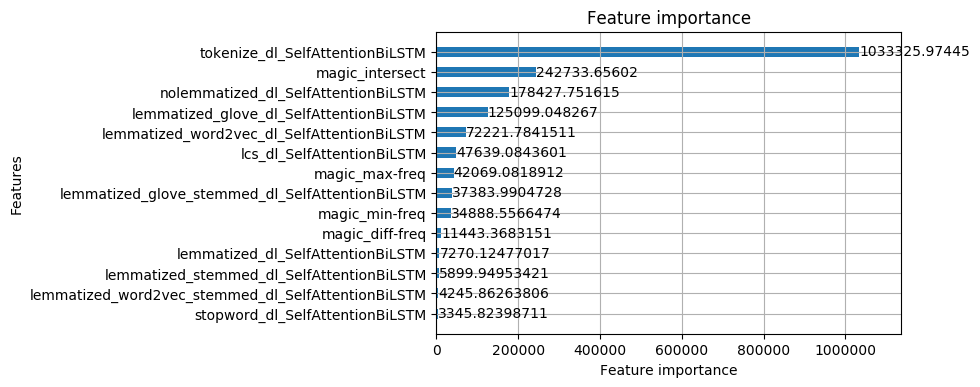

In [25]:
lgb.plot_importance(bst,max_num_features=None,height=0.5,importance_type='gain')

In [19]:
get_feature_importance(bst)

[(396, 'magic_max-freq'),
 (305, 'magic_intersect'),
 (300, 'nolemmatized_dl_SelfAttentionBiLSTM'),
 (286, 'tokenize_dl_SelfAttentionBiLSTM'),
 (269, 'lcs_dl_SelfAttentionBiLSTM'),
 (238, 'magic_min-freq'),
 (214, 'lemmatized_word2vec_dl_SelfAttentionBiLSTM'),
 (206, 'lemmatized_glove_stemmed_dl_SelfAttentionBiLSTM'),
 (186, 'lemmatized_glove_dl_SelfAttentionBiLSTM'),
 (162, 'stopword_dl_SelfAttentionBiLSTM'),
 (147, 'lemmatized_dl_SelfAttentionBiLSTM'),
 (143, 'lemmatized_word2vec_stemmed_dl_SelfAttentionBiLSTM'),
 (118, 'lemmatized_stemmed_dl_SelfAttentionBiLSTM')]

In [ ]:
# Test
## load features
test_features = pd.read_csv(config.FEAT_TEST_DATA, index_col=0)

## bagging
predictions = []
from tqdm import tqdm
for i in range(K_FOLD):
    save_path = os.path.join(config.MODEL_DIR, '%s%d.txt' % (MODEL_PREFIX, i))
    bst = lgb.Booster(model_file=save_path)
    print('Loaded model from %s' %save_path)
    predictions.append(bst.predict(test_features))
    print('Predicted by the %dth model...' % i)

## save result
test_features['is_duplicate'] = np.stack(predictions, axis=1).mean(axis=1)
save_path = os.path.join(cofnig.PREDICT_DIR, 'lgb_submission.csv')
submission = test_features[['is_duplicate']]
submission.to_csv(save_path)
### reweight result
a = 0.445945945945946 #=(0.165 / 0.37)
b = 1.3253968253968254 #=(1 - 0.165) / (1 - 0.37)
reweight = lambda x : (a*x/(a*x + b*(1-x)))
submission['is_duplicate'] = submission['is_duplicate'].apply(reweight)
save_path = os.path.join(cofnig.PREDICT_DIR, 'lgb_submission_reweight.csv')
submission.to_csv(save_path)
# End Test


In [ ]:
frac = 0.060
a = frac / 0.1835
b = (1 - frac) / ( 1 - 0.1835)
f = lambda x: a* x/(a*x + b * (1 - x))

import numpy as np
sub = pd.read_csv("submission_nodl_with_dl9.csv")
pred = np.zeros_like(sub.is_duplicate, dtype='float64')
for i, (flag, x ) in enumerate(zip(test_inter.interset_count == 0, sub.is_duplicate)):
    if flag:
        pred[i] = f(x)
    else:
        pred[i] = x
    
print sub.is_duplicate.describe()
sub.is_duplicate = pred
print sub.is_duplicate.describe()
sub.to_csv("%s_reweight_submission_nodl_with_dl9.csv" % frac, index=False)